<h1 align=center> Segmenting and clustering neighborhoods in Stockholm </h1>

## Introduction

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
!pip install numpy
import numpy as np # library to handle data in a vectorized manner

import sys

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!pip install geopy # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

from sklearn.metrics import pairwise_distances

!pip install folium
import folium # map rendering library

# import ElbowVisualizer for Elbow method
!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

print('Libraries imported.')




     |████████████████████████████████| 94 kB 3.5 MB/s eta 0:00:011
     |████████████████████████████████| 271 kB 15.0 MB/s eta 0:00:01
Libraries imported.


Fetching data with Stockholm Boroughs, Neighborhoods and Location

In [2]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='XXXXXXXXXXXXXXXXXXXXXXXXXX',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_XXXXXXXXXXXXXXXXXXXXXXX.get_object(Bucket='courseracapstone-donotdelete-pr-ixdytpdtjenmxg',Key='Stockholm Boroughs.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_sthlm = pd.read_csv(body)
df_sthlm.head()


,Borough,Neighborhood,Latitude,Longitude
0,Älvsjö,Herrängen,59.274956,17.958920
1,Älvsjö,Långsjö,59.269330,17.973198
2,Älvsjö,Långbro,59.281099,17.967651
3,Älvsjö,Älvsjö,59.274411,17.997809
4,Älvsjö,Solberga,59.285274,17.994111


Visualize the number of neighborhoods by boroughs

In [3]:
df_sthlm.groupby('Borough').count()

,Neighborhood,Latitude,Longitude
Borough,,,
Bromma,24,24,24
Enskede-Årsta-Vantör,12,12,12
Farsta,10,10,10
Hägersten-Liljeholmen,10,10,10
Hässelby-Vällingby,9,9,9
Kungsholmen,6,6,6
Norrmalm,3,3,3
Rinkeby-Kista,4,4,4
Skarpnäck,9,9,9


Make sure that the data has all 14 boroughs and 116 neighborhoods

In [4]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df_sthlm['Borough'].unique()),
        df_sthlm.shape[0]
    )
)

The dataframe has 14 boroughs and 116 neighborhoods.


Use geopy library to get the latitude and longitude values

In [5]:
address = 'Stockholm'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Stockholm are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Stockholm are 59.3251172, 18.0710935.


Create a map of Stockholm with neighborhoods superimposed on top

In [6]:
# create map of New York using latitude and longitude values
map_sthlm = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_sthlm['Latitude'], df_sthlm['Longitude'], df_sthlm['Borough'], df_sthlm['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sthlm)  
    
map_sthlm

### Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them


Define Foursquare Credentials and Version

In [7]:
CLIENT_ID = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare Secret
ACCESS_TOKEN = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # your FourSquare Access Token
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: FGCPXOTEX54HN2IIXOFTE4MAYTK2A3DP202R2CHMDHD0H1P3
CLIENT_SECRET:QW5XS2QXI51QC2HL5U3KMYVCEUV51OEYHRYZAQDRBWJQ3O3Y


Explore the first neighborhood in the dataframe

In [8]:
df_sthlm.loc[0, 'Neighborhood']

'Herrängen'

In [9]:
neighborhood_latitude = df_sthlm.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df_sthlm.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df_sthlm.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Herrängen are 59.274955799999994, 17.958920199999998.


Now, let's get the top 100 venues that are in Herrängen within a radius of 500 meters.

In [10]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=FGCPXOTEX54HN2IIXOFTE4MAYTK2A3DP202R2CHMDHD0H1P3&client_secret=QW5XS2QXI51QC2HL5U3KMYVCEUV51OEYHRYZAQDRBWJQ3O3Y&v=20180605&ll=59.274955799999994,17.958920199999998&radius=500&limit=100'

Send the GET request and examine the results

In [11]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '6039667e4253cd5b56675b74'},
 'response': {'headerLocation': 'Herrängen',
  'headerFullLocation': 'Herrängen, Stockholm',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 5,
  'suggestedBounds': {'ne': {'lat': 59.279455804499996,
    'lng': 17.967711427166968},
   'sw': {'lat': 59.27045579549999, 'lng': 17.950128972833028}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bca0d7d3740b71325ea5f65',
       'name': 'Herrängens Gård',
       'location': {'address': 'Segeltorpsvägen 49',
        'lat': 59.27318879999999,
        'lng': 17.9605047,
        'labeledLatLngs': [{'label': 'display',
          'lat': 59.27318879999999,
          'lng': 17.9605047}],
        'distance': 216,
        'postalCode': '125 53',
       

In [12]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Clean the json and structure it into a pandas dataframe

In [13]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng
0,Herrängens Gård,Café,59.273189,17.960505
1,Gunnars Pizza,Pizza Place,59.275703,17.961032
2,Långsjön,Lake,59.273807,17.955407
3,Stima Huddinge,Electronics Store,59.271289,17.955266
4,Tempo,Supermarket,59.271589,17.953757


Number of venues returned

In [14]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

5 venues were returned by Foursquare.


### Create a function to repeat the same process to all neighborhoods in Stockholm

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Run the above function on each neighborhood and create a new dataframe

In [16]:
# type your answer here
sthlm_venues = getNearbyVenues(names=df_sthlm['Neighborhood'],
                                   latitudes=df_sthlm['Latitude'],
                                   longitudes=df_sthlm['Longitude']
                                  )

Herrängen
Långsjö
Långbro
Älvsjö
Solberga
Örby Slott
Liseberg
Abrahamsberg
Alvik
Beckomberga
Blackeberg
Bromma kyrka
Bällsta
Eneby
Höglandet
Mariehäll
Nockeby
Nockebyhov
Norra Ängby
Olovslund
Riksby
Smedslätten
Stora Mossen
Södra Ängby
Traneberg
Ulvsunda
Ulvsunda Industriområde
Åkeshov
Åkeslund
Ålsten
Äppelviken
Enskedefältet
Enskede Gård
Gamla Enskede
Johanneshov
Stureby
Årsta
Östberga
Bandhagen
Högdalen
Örby
Rågsved
Hagsätra
Fagersjö
Farsta
Farsta strand
Farstanäset
Gubbängen
Hökarängen
Larsboda
Sköndal
Svedmyra
Tallkrogen
Aspudden
Fruängen
Gröndal
Hägersten
Hägerstensåsen
Liljeholmen
Midsommarkransen
Mälarhöjden
Västberga
Västertorp
Hässelby Gård
Hässelby Strand
Hässelby Villastad
Vällingby
Backlura
Kälvesta
Nälsta
Råcksta
Vinsta
Fredhäll
Kristineberg
Lilla Essingen
Marieberg
Stadshagen
Stora Essingen
Norrmalm
Skeppsholmen
Vasastaden
Östermalm
Djurgården
Hjorthagen
Ladugårdsgärdet
Norra Djurgården
Akalla
Husby
Kista
Rinkeby
Bredäng
Skärholmen
Sätra
Vårberg
Bagarmossen
Björkhagen
Ens

Check the size of the resulting dataframe

In [17]:
print(sthlm_venues.shape)
sthlm_venues.head()

(989, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Herrängen,59.274956,17.95892,Herrängens Gård,59.273189,17.960505,Café
1,Herrängen,59.274956,17.95892,Gunnars Pizza,59.275703,17.961032,Pizza Place
2,Herrängen,59.274956,17.95892,Långsjön,59.273807,17.955407,Lake
3,Herrängen,59.274956,17.95892,Stima Huddinge,59.271289,17.955266,Electronics Store
4,Herrängen,59.274956,17.95892,Tempo,59.271589,17.953757,Supermarket


Descriptive statistics (initial dataset)

In [18]:
sthlm_venues.describe()

,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude
count,989.000000,989.000000,989.000000,989.000000
mean,59.319237,18.011615,59.319361,18.012073
std,0.031318,0.067972,0.031289,0.068067
min,59.234989,17.797872,59.237266,17.798779
25%,59.297628,17.977108,59.298160,17.978919
50%,59.325149,18.018109,59.324800,18.022604
75%,59.337695,18.064375,59.338262,18.070059
max,59.415741,18.173375,59.415741,18.177207


#### Top 10 categories of venues in Stockholm

In [19]:
sthlm_venues[["Venue Category", "Venue"]].groupby('Venue Category').count().sort_values('Venue', ascending=False).head(10)

,Venue
Venue Category,
Pizza Place,54
Café,49
Scandinavian Restaurant,41
Bus Stop,32
Park,30
Grocery Store,28
Thai Restaurant,28
Supermarket,27
Bakery,26


Alternative way of counting

In [20]:
sthlm_venues['Venue Category'].value_counts().head(10)

Pizza Place                54
Café                       49
Scandinavian Restaurant    41
Bus Stop                   32
Park                       30
Thai Restaurant            28
Grocery Store              28
Supermarket                27
Bakery                     26
Gym / Fitness Center       25
Name: Venue Category, dtype: int64

Let's find out how many unique categories can be curated from all the returned venues

In [21]:
print('There are {} uniques categories.'.format(len(sthlm_venues['Venue Category'].unique())))

There are 186 uniques categories.


Calculate the number of venues by neighborhood

In [22]:
sthlm_neigh = sthlm_venues[["Neighborhood", "Venue"]].groupby('Neighborhood').count().sort_values('Venue', ascending=False)
sthlm_neigh.head(10)

,Venue
Neighborhood,
Skeppsholmen,59
Stadshagen,41
Södermalm,36
Östermalm,32
Norrmalm,30
Ladugårdsgärdet,30
Midsommarkransen,30
Riddarholmen,27
Larsboda,24


#### Drop neighborhoods with less than 5 venues

In [23]:
sthlm_venues = sthlm_venues.groupby('Neighborhood').filter(lambda x : len(x)>5)
sthlm_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
9,Långbro,59.281099,17.967651,Långbro Värdshus,59.282808,17.970998,Scandinavian Restaurant
10,Långbro,59.281099,17.967651,Långbro Park,59.282241,17.972748,Park
11,Långbro,59.281099,17.967651,Pizzeria Lugano,59.283559,17.970690,Pizza Place
12,Långbro,59.281099,17.967651,Långbro Bakficka,59.281771,17.971549,Café
13,Långbro,59.281099,17.967651,Långbroparken (B),59.283292,17.971093,Bus Stop


Descriptive statistics (after subsetting)

In [24]:
sthlm_venues.describe()

,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude
count,793.000000,793.000000,793.000000,793.000000
mean,59.318385,18.024194,59.318523,18.024793
std,0.025925,0.055803,0.025813,0.055661
min,59.241444,17.841943,59.237266,17.835826
25%,59.301906,17.996029,59.300158,17.997000
50%,59.325046,18.027205,59.324751,18.029597
75%,59.336410,18.073594,59.335903,18.072500
max,59.373743,18.127062,59.375733,18.132740


#### Number of venues by neighborhood

In [25]:
sthlm_neigh = sthlm_venues[["Neighborhood", "Venue"]].groupby('Neighborhood').count().sort_values('Venue', ascending=False)
sthlm_neigh.head(10)

,Venue
Neighborhood,
Skeppsholmen,59
Stadshagen,41
Södermalm,36
Östermalm,32
Midsommarkransen,30
Ladugårdsgärdet,30
Norrmalm,30
Riddarholmen,27
Larsboda,24


#### Create histogram of venues from 52 neighborhoods

Text(0.5, 0, 'Number of venues')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


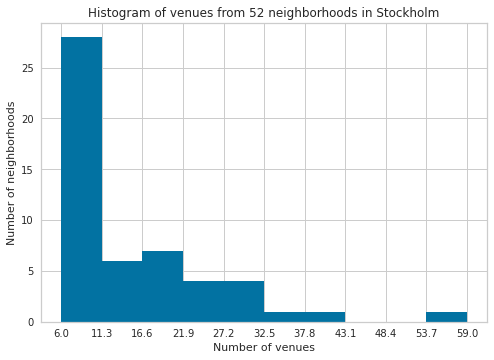

In [26]:
count, bin_edges = np.histogram(sthlm_neigh['Venue'], bins = 10)
sthlm_neigh['Venue'].plot(kind='hist', xticks= bin_edges)

plt.title('Histogram of venues from 52 neighborhoods in Stockholm')
plt.ylabel('Number of neighborhoods')
plt.xlabel('Number of venues')

In [27]:
sthlm_neigh.describe()

,Venue
count,52.000000
mean,15.250000
std,10.820958
min,6.000000
25%,7.000000
50%,10.500000
75%,20.000000
max,59.000000


Reprint the map with final neighborhoods

In [28]:
# create map of New York using latitude and longitude values
map_sthlm1 = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(sthlm_venues['Neighborhood Latitude'], sthlm_venues['Neighborhood Longitude'], sthlm_venues['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sthlm1)  
    
map_sthlm1

In [29]:
print('The dataframe has {} neighborhoods.'.format(
        len(sthlm_venues['Neighborhood'].unique()),
        sthlm_venues.shape[0]
    )
)

The dataframe has 52 neighborhoods.


In [30]:
sthlm_venues['Venue Category'].value_counts().head(10)

Café                       45
Scandinavian Restaurant    39
Pizza Place                39
Park                       27
Bakery                     24
Thai Restaurant            23
Gym / Fitness Center       22
Hotel                      21
Grocery Store              19
Convenience Store          19
Name: Venue Category, dtype: int64

Number of unique categories after subsetting

In [31]:
print('There are {} uniques categories.'.format(len(sthlm_venues['Venue Category'].unique())))

There are 164 uniques categories.


### Analyzing each neighborhood

In [32]:
# one hot encoding
sthlm_onehot = pd.get_dummies(sthlm_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sthlm_onehot['Neighborhood'] = sthlm_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [sthlm_onehot.columns[-1]] + list(sthlm_onehot.columns[:-1])
sthlm_onehot = sthlm_onehot[fixed_columns]

sthlm_onehot.head()

,Neighborhood,Airport Terminal,American Restaurant,Amphitheater,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Badminton Court,Bagel Shop,Bakery,Bar,Bathing Area,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Bistro,Boat or Ferry,Bookstore,Bowling Alley,Brazilian Restaurant,Burger Joint,Bus Station,Bus Stop,Café,Candy Store,Caribbean Restaurant,Castle,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,City Hall,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Construction & Landscaping,Convenience Store,Currency Exchange,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Disc Golf,Discount Store,Doctor's Office,Doner Restaurant,Electronics Store,Event Space,Falafel Restaurant,Fast Food Restaurant,Field,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Forest,French Restaurant,Fruit & Vegetable Store,Furniture / Home Store,Gastropub,General College & University,General Entertainment,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Kurdish Restaurant,Lake,Light Rail Station,Liquor Store,Lounge,Martial Arts School,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Movie Theater,Museum,Music Venue,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Gym,Outdoor Sculpture,Park,Pedestrian Plaza,Persian Restaurant,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pub,Racetrack,Restaurant,Rock Club,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shopping Mall,Soccer Field,South American Restaurant,Spanish Restaurant,Spiritual Center,Sporting Goods Shop,Squash Court,Stables,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Thrift / Vintage Store,Track,Trail,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
9,Långbro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,Långbro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,Långbro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,Långbro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,Långbro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Examine the new dataframe size

In [33]:
sthlm_onehot.shape

(793, 165)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [34]:
sthlm_grouped = sthlm_onehot.groupby('Neighborhood').mean().reset_index()
sthlm_grouped.head()

,Neighborhood,Airport Terminal,American Restaurant,Amphitheater,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Badminton Court,Bagel Shop,Bakery,Bar,Bathing Area,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Bistro,Boat or Ferry,Bookstore,Bowling Alley,Brazilian Restaurant,Burger Joint,Bus Station,Bus Stop,Café,Candy Store,Caribbean Restaurant,Castle,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,City Hall,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Construction & Landscaping,Convenience Store,Currency Exchange,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Disc Golf,Discount Store,Doctor's Office,Doner Restaurant,Electronics Store,Event Space,Falafel Restaurant,Fast Food Restaurant,Field,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Forest,French Restaurant,Fruit & Vegetable Store,Furniture / Home Store,Gastropub,General College & University,General Entertainment,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Kurdish Restaurant,Lake,Light Rail Station,Liquor Store,Lounge,Martial Arts School,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Movie Theater,Museum,Music Venue,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Gym,Outdoor Sculpture,Park,Pedestrian Plaza,Persian Restaurant,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pub,Racetrack,Restaurant,Rock Club,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shopping Mall,Soccer Field,South American Restaurant,Spanish Restaurant,Spiritual Center,Sporting Goods Shop,Squash Court,Stables,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Thrift / Vintage Store,Track,Trail,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,Alvik,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.100000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.100000,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.100000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.100000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0
1,Aspudden,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.0,0.066667,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.133333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.066667,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.066667,0.0,0.0,0.066667,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.0,0.0,0.0,0.200000,0.0,0.0,0.0,0.000000,0.0,0.066667,0.0,0.000000,0.0,0.0,0.0,0.066667,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.066667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Bagarmossen,0.0,0.0,0.0,0.

Let's confirm the new size

In [35]:
sthlm_grouped.shape

(52, 165)

### 1. Hierarchical clustering

In [36]:
featureset = sthlm_grouped.drop(['Neighborhood'], axis = 1) 
featureset.head()

,Airport Terminal,American Restaurant,Amphitheater,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Badminton Court,Bagel Shop,Bakery,Bar,Bathing Area,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Bistro,Boat or Ferry,Bookstore,Bowling Alley,Brazilian Restaurant,Burger Joint,Bus Station,Bus Stop,Café,Candy Store,Caribbean Restaurant,Castle,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,City Hall,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Construction & Landscaping,Convenience Store,Currency Exchange,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Disc Golf,Discount Store,Doctor's Office,Doner Restaurant,Electronics Store,Event Space,Falafel Restaurant,Fast Food Restaurant,Field,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Forest,French Restaurant,Fruit & Vegetable Store,Furniture / Home Store,Gastropub,General College & University,General Entertainment,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Kurdish Restaurant,Lake,Light Rail Station,Liquor Store,Lounge,Martial Arts School,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Movie Theater,Museum,Music Venue,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Gym,Outdoor Sculpture,Park,Pedestrian Plaza,Persian Restaurant,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pub,Racetrack,Restaurant,Rock Club,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shopping Mall,Soccer Field,South American Restaurant,Spanish Restaurant,Spiritual Center,Sporting Goods Shop,Squash Court,Stables,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Thrift / Vintage Store,Track,Trail,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.100000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.100000,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.100000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.100000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.0,0.066667,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.133333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.066667,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.066667,0.0,0.0,0.066667,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.0,0.0,0.0,0.200000,0.0,0.0,0.0,0.000000,0.0,0.066667,0.0,0.000000,0.0,0.0,0.0,0.066667,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.066667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.142

Normalize the dataset

In [37]:
from sklearn.preprocessing import MinMaxScaler
x = featureset.values #returns a numpy array
min_max_scaler = MinMaxScaler()
feature_mtx = min_max_scaler.fit_transform(x)
feature_mtx [0:5]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.7       , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.7       , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

First, we calculate the distance matrix.

In [38]:
import scipy
leng = feature_mtx.shape[0]
D = scipy.zeros([leng,leng])
for i in range(leng):
    for j in range(leng):
        D[i,j] = scipy.spatial.distance.euclidean(feature_mtx[i], feature_mtx[j])
D

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  app.launch_new_instance()


array([[0.        , 2.98546375, 2.93073962, ..., 3.00873728, 2.97576254,
        3.45484403],
       [2.98546375, 0.        , 2.77387299, ..., 3.10384071, 3.20625633,
        3.64528569],
       [2.93073962, 2.77387299, 0.        , ..., 2.93640068, 3.1195681 ,
        3.60240542],
       ...,
       [3.00873728, 3.10384071, 2.93640068, ..., 0.        , 3.27736545,
        3.67878339],
       [2.97576254, 3.20625633, 3.1195681 , ..., 3.27736545, 0.        ,
        3.61694123],
       [3.45484403, 3.64528569, 3.60240542, ..., 3.67878339, 3.61694123,
        0.        ]])

Cluster using "complete"

In [39]:
import pylab
from scipy.cluster import hierarchy
import scipy.cluster.hierarchy
Z = hierarchy.linkage(D, 'complete')

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


Essentially, Hierarchical clustering does not require a pre-specified number of clusters. However, in some applications we want a partition of disjoint clusters just as in flat clustering. So you can use a cutting line:

In [40]:
from scipy.cluster.hierarchy import fcluster
max_d = 3
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([21, 17,  1, 27, 46, 39, 12,  8, 19, 31, 42, 28, 43, 18,  4, 37,  6,
       44, 16, 15, 13, 30, 36, 10, 34, 15,  3, 45, 29, 14, 31,  9, 47, 35,
       40, 38, 23,  2, 50, 49, 22,  5, 24,  7, 25, 11, 20, 32, 41, 26, 33,
       48], dtype=int32)

Also, you can determine the number of clusters directly:

In [41]:
from scipy.cluster.hierarchy import fcluster
k = 5
clusters = fcluster(Z, k, criterion='maxclust')
clusters

array([1, 1, 1, 1, 4, 3, 1, 1, 1, 2, 4, 1, 4, 1, 1, 3, 1, 4, 1, 1, 1, 1,
       3, 1, 3, 1, 1, 4, 1, 1, 2, 1, 4, 3, 3, 3, 1, 1, 5, 4, 1, 1, 1, 1,
       1, 1, 1, 3, 3, 1, 3, 4], dtype=int32)

Now, plot the dendrogram:

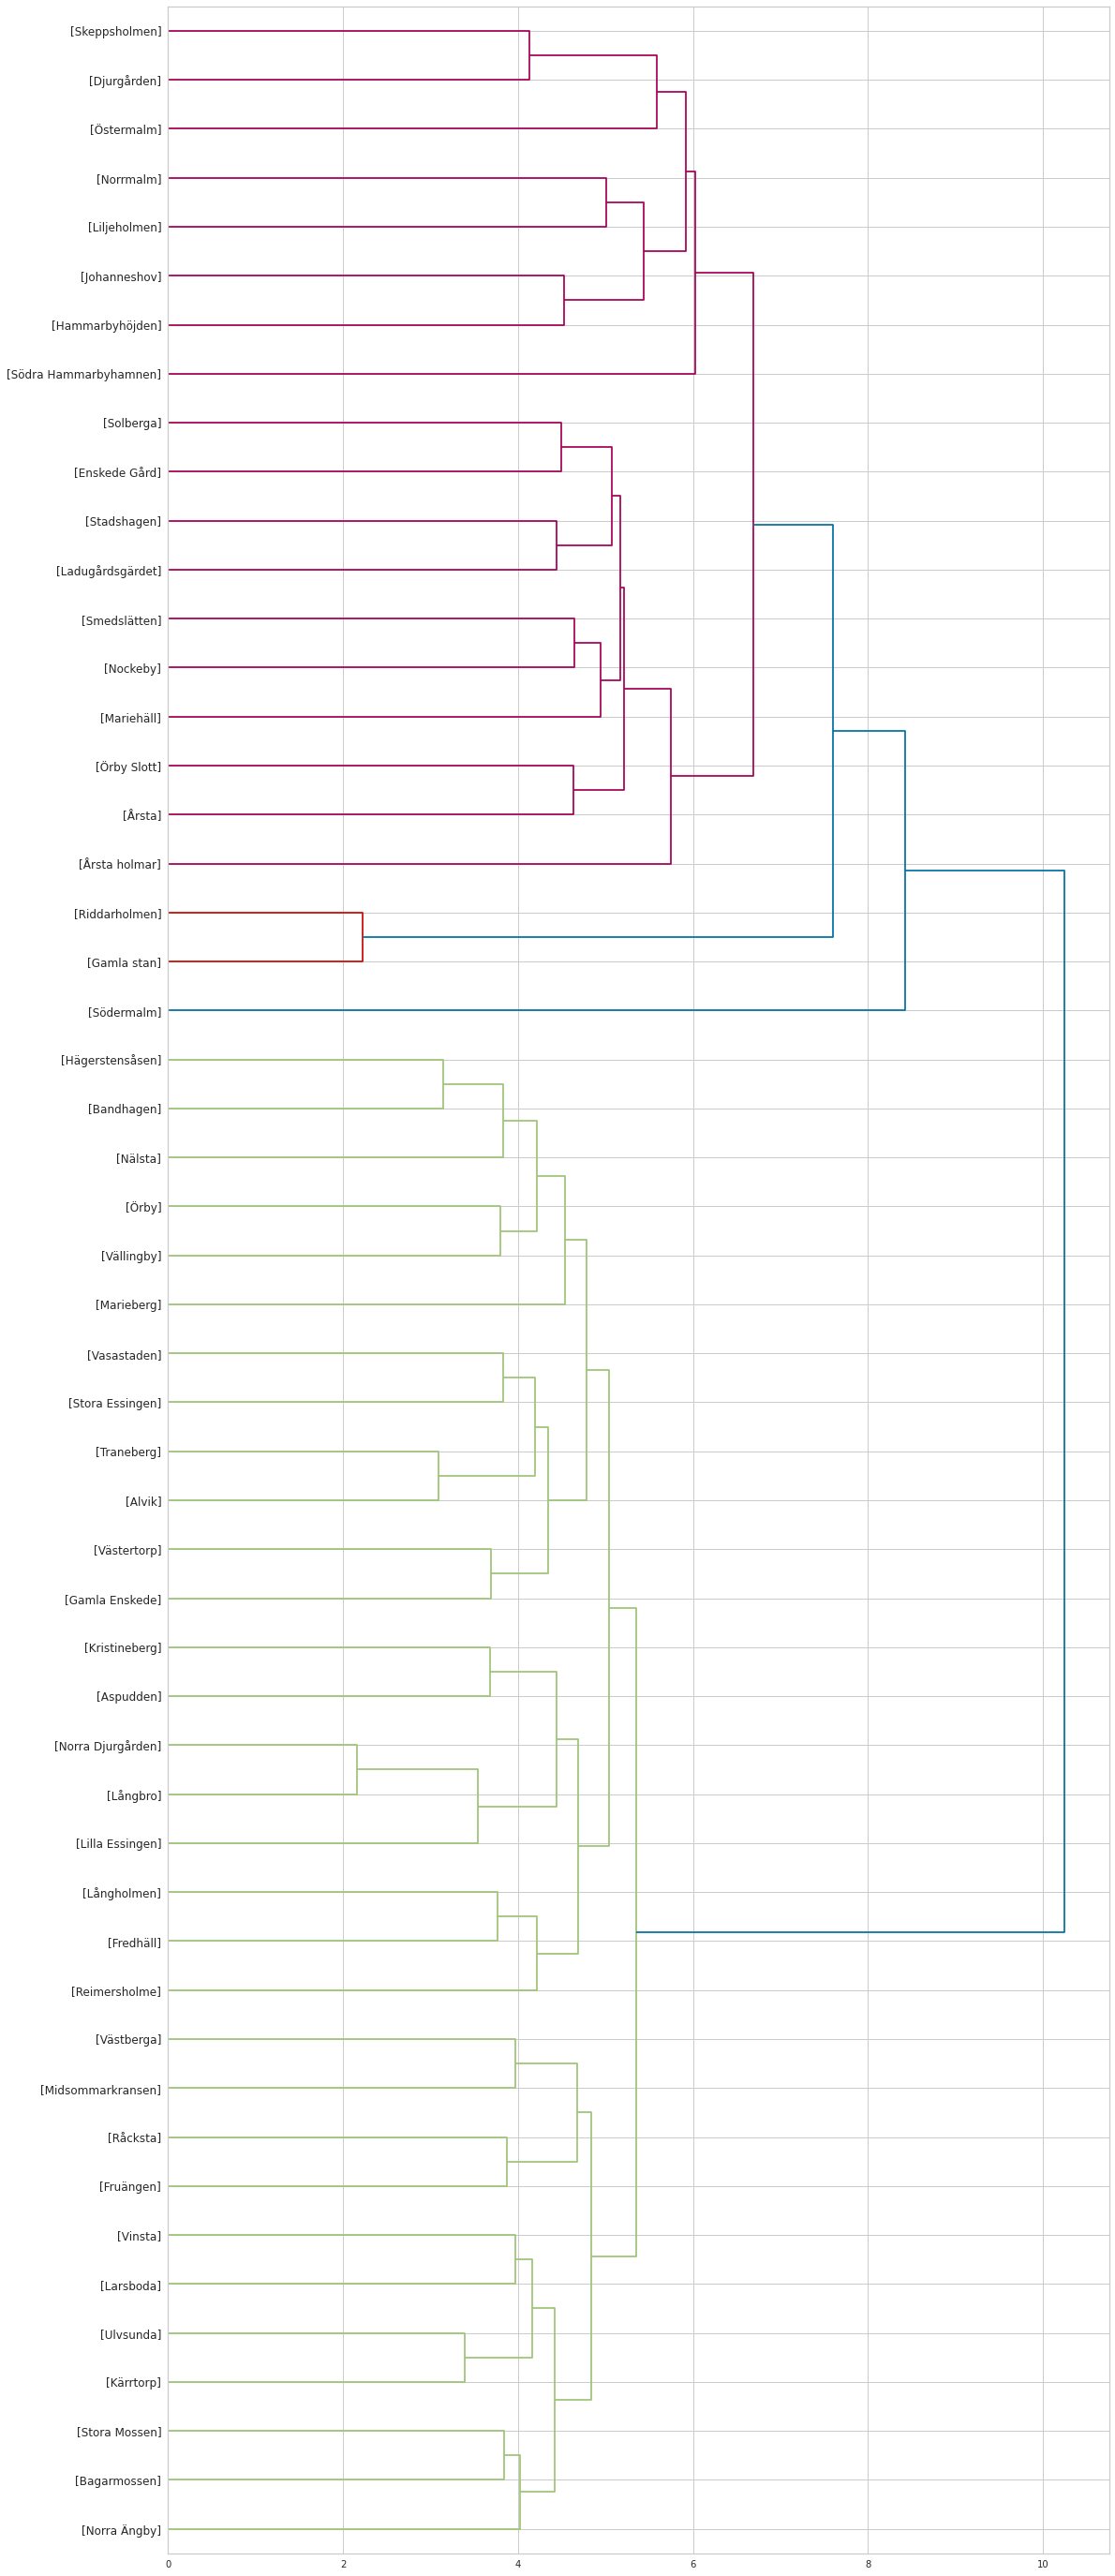

In [42]:
fig = pylab.figure(figsize=(18,50))
def llf(id):
    return '[%s]' % (sthlm_grouped['Neighborhood'][id])
    
dendro = hierarchy.dendrogram(Z,  leaf_label_func=llf, leaf_rotation=0, leaf_font_size =12, orientation = 'right')

### 2. Determine the optimal number of clusters

In [43]:
sthlm_grouped_clustering = sthlm_grouped.drop('Neighborhood', 1)

### 2.1 The Elbow method

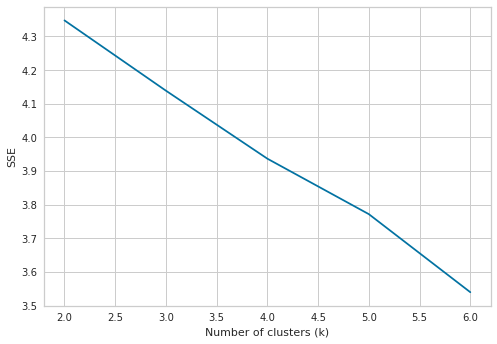

In [44]:
sse = {}
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=1).fit(sthlm_grouped_clustering)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters (k)")
plt.ylabel("SSE")
plt.show()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/yellowbrick/utils/kneed.py:155: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


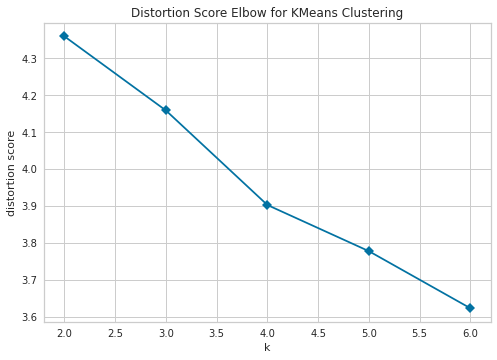

In [45]:
# Elbow Method for K means# Import ElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,7), timings= False)
visualizer.fit(sthlm_grouped_clustering)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

#Source: https://www.scikit-yb.org/en/latest/api/cluster/elbow.html

### 2.2 Silhouette method

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.07659122178911676
For n_clusters = 3 The average silhouette_score is : 0.07208938540144556
For n_clusters = 4 The average silhouette_score is : 0.044195737697660484
For n_clusters = 5 The average silhouette_score is : 0.058959082241520536


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


For n_clusters = 6 The average silhouette_score is : 0.07686076062710365


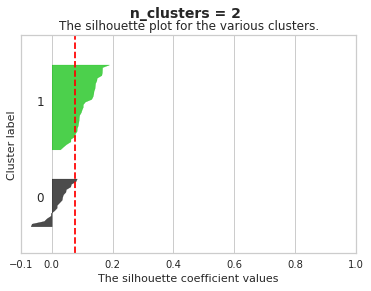

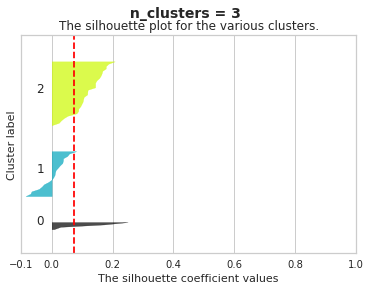

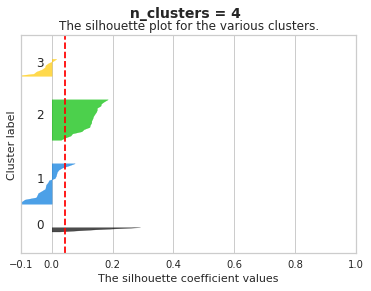

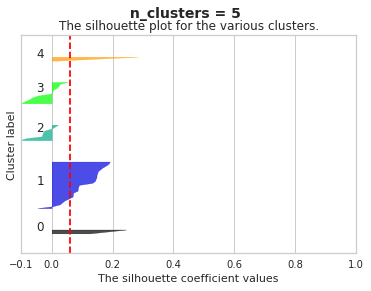

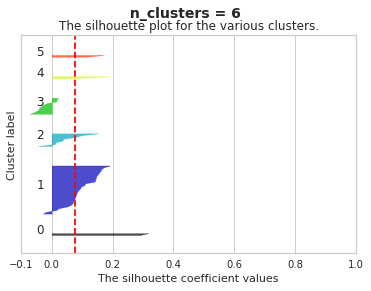

In [46]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

X = sthlm_grouped_clustering  # The dataset

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1)
    fig.set_size_inches(6, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    plt.suptitle((" n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()
# Source: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

In [ ]:
range_n_clusters = [2, 3, 4, 5, 6]
elbow = []
ss = []
for n_clusters in range_n_clusters:
   #iterating through cluster sizes
   clusterer = KMeans(n_clusters = n_clusters, random_state=42)
   cluster_labels = clusterer.fit_predict(sthlm_grouped_clustering)
   #Finding the average silhouette score
   silhouette_avg = silhouette_score(sthlm_grouped_clustering, cluster_labels)
   ss.append(silhouette_avg)
   #print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_avg)`
   #Finding the average SSE"
   elbow.append(clusterer.inertia_) # Inertia: Sum of distances of samples to their closest cluster center
fig = plt.figure(figsize=(14,7))
#fig.add_subplot(121)
#plt.plot(range_n_clusters, elbow,'b-',label='Sum of squared error')
#plt.xlabel("Number of cluster")
#plt.ylabel("SSE")
#plt.legend()
fig.add_subplot(122)
plt.plot(range_n_clusters, ss,'b-',label='Silhouette Score')
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()

#Source: https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion

### 2.3 Gap statistic method

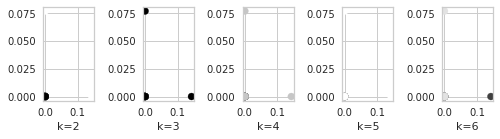

In [48]:
X = sthlm_grouped_clustering

for k in range(2,7):
    kmeans = KMeans(n_clusters=k)
    a = kmeans.fit_predict(X)
    plt.subplot(3,6,k)
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=a)
    plt.xlabel('k='+str(k))
plt.tight_layout()
plt.show()

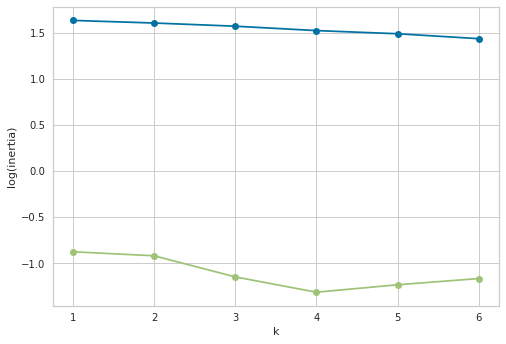

In [49]:
def compute_inertia(a, X):
    W = [np.mean(pairwise_distances(X[a == c, :])) for c in np.unique(a)]
    return np.mean(W)

def compute_gap(clustering, data, k_max=6, n_references=6):
    if len(data.shape) == 1:
        data = data.reshape(-1, 1)
    reference = np.random.rand(*data.shape)
    reference_inertia = []
    for k in range(1, k_max+1):
        local_inertia = []
        for _ in range(n_references):
            clustering.n_clusters = k
            assignments = clustering.fit_predict(reference)
            local_inertia.append(compute_inertia(assignments, reference))
        reference_inertia.append(np.mean(local_inertia))
    
    ondata_inertia = []
    for k in range(1, k_max+1):
        clustering.n_clusters = k
        assignments = clustering.fit_predict(data)
        ondata_inertia.append(compute_inertia(assignments, data))
        
    gap = np.log(reference_inertia)-np.log(ondata_inertia)
    return gap, np.log(reference_inertia), np.log(ondata_inertia)

k_max = 6
gap, reference_inertia, ondata_inertia = compute_gap(KMeans(), X.values, k_max)


plt.plot(range(1, k_max+1), reference_inertia,
         '-o', label='reference')
plt.plot(range(1, k_max+1), ondata_inertia,
         '-o', label='data')
plt.xlabel('k')
plt.ylabel('log(inertia)')
plt.show()

# Source: https://glowingpython.blogspot.com/2019/01/a-visual-introduction-to-gap-statistics.html

Text(0.5, 0, 'k')

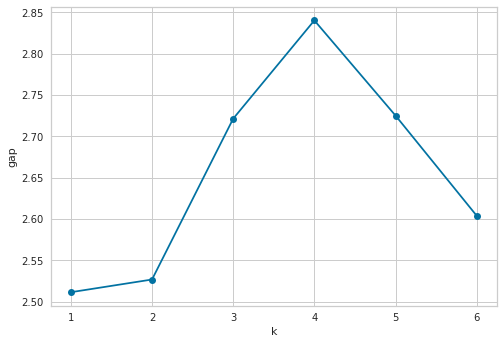

In [50]:
plt.plot(range(1, k_max+1), gap, '-o')
plt.ylabel('gap')
plt.xlabel('k')

# Source: https://glowingpython.blogspot.com/2019/01/a-visual-introduction-to-gap-statistics.html

### Analyzing each neighborhood

Let's run onehot encoding

In [51]:
# one hot encoding
sthlm_onehot = pd.get_dummies(sthlm_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sthlm_onehot['Neighborhood'] = sthlm_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [sthlm_onehot.columns[-1]] + list(sthlm_onehot.columns[:-1])
sthlm_onehot = sthlm_onehot[fixed_columns]

sthlm_onehot.head()

,Neighborhood,Airport Terminal,American Restaurant,Amphitheater,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Badminton Court,Bagel Shop,Bakery,Bar,Bathing Area,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Bistro,Boat or Ferry,Bookstore,Bowling Alley,Brazilian Restaurant,Burger Joint,Bus Station,Bus Stop,Café,Candy Store,Caribbean Restaurant,Castle,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,City Hall,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Construction & Landscaping,Convenience Store,Currency Exchange,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Disc Golf,Discount Store,Doctor's Office,Doner Restaurant,Electronics Store,Event Space,Falafel Restaurant,Fast Food Restaurant,Field,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Forest,French Restaurant,Fruit & Vegetable Store,Furniture / Home Store,Gastropub,General College & University,General Entertainment,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Kurdish Restaurant,Lake,Light Rail Station,Liquor Store,Lounge,Martial Arts School,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Movie Theater,Museum,Music Venue,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Gym,Outdoor Sculpture,Park,Pedestrian Plaza,Persian Restaurant,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pub,Racetrack,Restaurant,Rock Club,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shopping Mall,Soccer Field,South American Restaurant,Spanish Restaurant,Spiritual Center,Sporting Goods Shop,Squash Court,Stables,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Thrift / Vintage Store,Track,Trail,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
9,Långbro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,Långbro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,Långbro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,Långbro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,Långbro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Examing the new dataframe size

In [52]:
sthlm_onehot.shape

(793, 165)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [53]:
sthlm_grouped = sthlm_onehot.groupby('Neighborhood').mean().reset_index()
sthlm_grouped.head()

,Neighborhood,Airport Terminal,American Restaurant,Amphitheater,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Badminton Court,Bagel Shop,Bakery,Bar,Bathing Area,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Bistro,Boat or Ferry,Bookstore,Bowling Alley,Brazilian Restaurant,Burger Joint,Bus Station,Bus Stop,Café,Candy Store,Caribbean Restaurant,Castle,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,City Hall,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Construction & Landscaping,Convenience Store,Currency Exchange,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Disc Golf,Discount Store,Doctor's Office,Doner Restaurant,Electronics Store,Event Space,Falafel Restaurant,Fast Food Restaurant,Field,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Forest,French Restaurant,Fruit & Vegetable Store,Furniture / Home Store,Gastropub,General College & University,General Entertainment,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Kurdish Restaurant,Lake,Light Rail Station,Liquor Store,Lounge,Martial Arts School,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Movie Theater,Museum,Music Venue,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Gym,Outdoor Sculpture,Park,Pedestrian Plaza,Persian Restaurant,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pub,Racetrack,Restaurant,Rock Club,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shopping Mall,Soccer Field,South American Restaurant,Spanish Restaurant,Spiritual Center,Sporting Goods Shop,Squash Court,Stables,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Thrift / Vintage Store,Track,Trail,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,Alvik,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.100000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.100000,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.100000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.100000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0
1,Aspudden,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.0,0.066667,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.133333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.066667,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.066667,0.0,0.0,0.066667,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.0,0.0,0.0,0.200000,0.0,0.0,0.0,0.000000,0.0,0.066667,0.0,0.000000,0.0,0.0,0.0,0.066667,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.066667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Bagarmossen,0.0,0.0,0.0,0.

Let's confirm the new size

In [54]:
sthlm_grouped.shape

(52, 165)

Print each neighborhood along with the top 5 most common venues

In [55]:
num_top_venues = 5

for hood in sthlm_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = sthlm_grouped[sthlm_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Alvik----
                    venue  freq
0         Thai Restaurant   0.2
1      Italian Restaurant   0.1
2                  Bakery   0.1
3              Restaurant   0.1
4  Furniture / Home Store   0.1


----Aspudden----
       venue  freq
0       Park  0.20
1       Café  0.13
2  Mini Golf  0.07
3     Bakery  0.07
4        Pub  0.07


----Bagarmossen----
              venue  freq
0          Pharmacy  0.14
1               Pub  0.14
2     Metro Station  0.14
3       Supermarket  0.14
4  Sushi Restaurant  0.14


----Bandhagen----
           venue  freq
0     Playground  0.11
1     Hobby Shop  0.11
2           Café  0.11
3    Pizza Place  0.11
4  Metro Station  0.11


----Djurgården----
                     venue  freq
0                   Museum  0.14
1  Scandinavian Restaurant  0.14
2               Art Museum  0.09
3           History Museum  0.09
4                     Café  0.09


----Enskede Gård----
                    venue  freq
0  Furniture / Home Store  0.14
1                 S

4            Grocery Store  0.14


----Västberga----
                  venue  freq
0           Bus Station  0.16
1                  Café  0.11
2     Indian Restaurant  0.05
3  Gym / Fitness Center  0.05
4  Fast Food Restaurant  0.05


----Västertorp----
                     venue  freq
0              Pizza Place  0.25
1  Scandinavian Restaurant  0.12
2        Convenience Store  0.12
3                    Hotel  0.12
4       Athletics & Sports  0.12


----Årsta----
                  venue  freq
0    Light Rail Station  0.11
1  Fast Food Restaurant  0.11
2          Soccer Field  0.06
3                  Park  0.06
4         Grocery Store  0.06


----Årsta holmar----
              venue  freq
0          Bus Stop  0.18
1              Pier  0.09
2  Sushi Restaurant  0.09
3      Burger Joint  0.09
4         Juice Bar  0.09


----Örby----
                        venue  freq
0                 Pizza Place  0.33
1  Construction & Landscaping  0.17
2               Grocery Store  0.17
3             

Sort venues in descending order

In [56]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create the new dataframe and display the top 10 venues for each neighborhood

In [57]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = sthlm_grouped['Neighborhood']

for ind in np.arange(sthlm_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sthlm_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alvik,Thai Restaurant,Hotel,Pizza Place,Tram Station,Martial Arts School,Italian Restaurant,Furniture / Home Store,Restaurant,Bakery,Event Space
1,Aspudden,Park,Café,Bakery,Mini Golf,Supermarket,Beach,Bathing Area,Pub,Metro Station,Other Great Outdoors
2,Bagarmossen,Pharmacy,Pub,Fast Food Restaurant,Supermarket,Sushi Restaurant,Bakery,Metro Station,Discount Store,Food & Drink Shop,Food
3,Bandhagen,Bus Station,Hobby Shop,Pizza Place,Metro Station,Playground,Café,Mediterranean Restaurant,Grocery Store,Sushi Restaurant,Falafel Restaurant
4,Djurgården,Scandinavian Restaurant,Museum,Café,History Museum,Art Museum,Hotel,Restaurant,Park,Hostel,Coffee Shop


### 3. Cluster neighborhoods

Run k-means to cluster the neighborhood into 5 clusters

In [58]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sthlm_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 1, 1, 2, 2, 3, 1, 1, 2], dtype=int32)

Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [59]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

sthlm_merged = df_sthlm

# merge sthlm_grouped with sthlm_data to add latitude/longitude for each neighborhood
sthlm_merged = sthlm_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood', how ='inner')

sthlm_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Älvsjö,Långbro,59.281099,17.967651,2,Pizza Place,Park,Bus Stop,Café,Scandinavian Restaurant,Fast Food Restaurant,Event Space,Flower Shop,Flea Market,Field
4,Älvsjö,Solberga,59.285274,17.994111,2,Pizza Place,Scandinavian Restaurant,Trail,Athletics & Sports,Greek Restaurant,Kurdish Restaurant,Yoga Studio,Event Space,Food,Flower Shop
5,Älvsjö,Örby Slott,59.281908,18.013395,2,Café,Pharmacy,Italian Restaurant,Coffee Shop,Platform,Plaza,Shopping Mall,Supermarket,Gym / Fitness Center,Convenience Store
8,Bromma,Alvik,59.331280,17.971008,2,Thai Restaurant,Hotel,Pizza Place,Tram Station,Martial Arts School,Italian Restaurant,Furniture / Home Store,Restaurant,Bakery,Event Space
15,Bromma,Mariehäll,59.361758,17.941360,2,Airport Terminal,Grocery Store,Racetrack,Flea Market,Middle Eastern Restaurant,Sushi Restaurant,Convenience Store,Hawaiian Restaurant,Harbor / Marina,Hockey Arena


Visualize the resulting clusters

In [60]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sthlm_merged['Latitude'], sthlm_merged['Longitude'], sthlm_merged['Neighborhood'], sthlm_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Describing the clusters

Calculate number of venues and percentages for each cluster

In [61]:
# Create a new category with cluster labels and neighborhoods
cluster_info=sthlm_merged[['Cluster Labels','Neighborhood']]
cluster_info.head()

,Cluster Labels,Neighborhood
2,2,Långbro
4,2,Solberga
5,2,Örby Slott
8,2,Alvik
15,2,Mariehäll


In [62]:
desc_cluster = sthlm_venues
desc_cluster = desc_cluster.merge(cluster_info, how="left", on="Neighborhood")
desc_cluster.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels
0,Långbro,59.281099,17.967651,Långbro Värdshus,59.282808,17.970998,Scandinavian Restaurant,2
1,Långbro,59.281099,17.967651,Långbro Park,59.282241,17.972748,Park,2
2,Långbro,59.281099,17.967651,Pizzeria Lugano,59.283559,17.970690,Pizza Place,2
3,Långbro,59.281099,17.967651,Långbro Bakficka,59.281771,17.971549,Café,2
4,Långbro,59.281099,17.967651,Långbroparken (B),59.283292,17.971093,Bus Stop,2


In [63]:
desc_cluster = desc_cluster[['Neighborhood','Venue','Venue Category','Cluster Labels']]
desc_cluster.head()

,Neighborhood,Venue,Venue Category,Cluster Labels
0,Långbro,Långbro Värdshus,Scandinavian Restaurant,2
1,Långbro,Långbro Park,Park,2
2,Långbro,Pizzeria Lugano,Pizza Place,2
3,Långbro,Långbro Bakficka,Café,2
4,Långbro,Långbroparken (B),Bus Stop,2


Calculate how many Venue Category are in each cluser in absolute and relative numbers

In [64]:
grouped_cluster = desc_cluster.groupby(['Cluster Labels','Venue Category'])['Venue'].count().reset_index()
grouped_cluster = grouped_cluster.sort_values(by=['Venue'], ascending=False)
grouped_cluster.head()

,Cluster Labels,Venue Category,Venue
82,2,Café,37
183,2,Scandinavian Restaurant,34
165,2,Park,26
202,2,Thai Restaurant,21
67,2,Bakery,21


Now, let's calculate the number of venue categories for each cluster

#### Describe cluster 0

In [65]:
grouped_cluster_0 = grouped_cluster[grouped_cluster['Cluster Labels'] == 0]
grouped_cluster_0['%'] = round(grouped_cluster_0['Venue']/grouped_cluster_0['Venue'].sum()*100, 2)
grouped_cluster_0['%'] = grouped_cluster_0['%'].astype(str) +'%'
grouped_cluster_0.head(10)

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,Cluster Labels,Venue Category,Venue,%
5,0,Supermarket,2,28.57%
0,0,Event Space,1,14.29%
2,0,Grocery Store,1,14.29%
3,0,Metro Station,1,14.29%
4,0,Scandinavian Restaurant,1,14.29%
1,0,Fast Food Restaurant,1,14.29%


##### Describe cluster 1

In [66]:
grouped_cluster_1 = grouped_cluster[grouped_cluster['Cluster Labels'] == 1]
grouped_cluster_1['%'] = round(grouped_cluster_1['Venue']/grouped_cluster_1['Venue'].sum()*100, 2)
grouped_cluster_1['%'] = grouped_cluster_1['%'].astype(str) +'%'
grouped_cluster_1.head(10)

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,Cluster Labels,Venue Category,Venue,%
41,1,Pizza Place,19,14.62%
38,1,Metro Station,11,8.46%
29,1,Grocery Store,8,6.15%
30,1,Gym / Fitness Center,6,4.62%
50,1,Supermarket,6,4.62%
51,1,Sushi Restaurant,5,3.85%
18,1,Convenience Store,5,3.85%
10,1,Bus Station,4,3.08%
11,1,Bus Stop,4,3.08%
12,1,Café,4,3.08%


#### Describe cluster 2

In [67]:
grouped_cluster_2 = grouped_cluster[grouped_cluster['Cluster Labels'] == 2]
grouped_cluster_2['%'] = round(grouped_cluster_2['Venue']/grouped_cluster_2['Venue'].sum()*100, 2)
grouped_cluster_2['%'] = grouped_cluster_2['%'].astype(str) +'%'
grouped_cluster_2.head(10)

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,Cluster Labels,Venue Category,Venue,%
82,2,Café,37,5.85%
183,2,Scandinavian Restaurant,34,5.37%
165,2,Park,26,4.11%
202,2,Thai Restaurant,21,3.32%
67,2,Bakery,21,3.32%
171,2,Pizza Place,20,3.16%
179,2,Restaurant,16,2.53%
120,2,Gym / Fitness Center,16,2.53%
128,2,Hotel,16,2.53%
134,2,Italian Restaurant,15,2.37%


#### Describe cluster 3

In [68]:
grouped_cluster_3 = grouped_cluster[grouped_cluster['Cluster Labels'] == 3]
grouped_cluster_3['%'] = round(grouped_cluster_3['Venue']/grouped_cluster_3['Venue'].sum()*100, 2)
grouped_cluster_3['%'] = grouped_cluster_3['%'].astype(str) +'%'
grouped_cluster_3.head(10)

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,Cluster Labels,Venue Category,Venue,%
212,3,Beach,6,26.09%
214,3,Café,4,17.39%
221,3,Scandinavian Restaurant,3,13.04%
213,3,Bus Stop,2,8.7%
219,3,Modern European Restaurant,1,4.35%
220,3,Park,1,4.35%
222,3,Supermarket,1,4.35%
218,3,Hotel,1,4.35%
217,3,History Museum,1,4.35%
216,3,Event Space,1,4.35%
